# BUAI446 Capstone Project: Recommender System Based on Online Reviews
  
**Dataset:** `Amazon_Last_Three_Years_Data.xlsx`  
Dataset Relative Path: `data/Amazon_Last_Three_Years_Data.xlsx`  
Group Members: Ruihuang Yang, Priyanshi Gupta  
CWRU NetIDs: rxy216, pxg398  
Due Date: 2025-12-02  


This notebook implements the full analytics plan for building a hybrid recommender system that combines collaborative filtering, content-based methods, and advanced NLP-driven features on top of Amazon Musical Instruments reviews. The workflow mirrors the project rubric:

1. **Problem formulation & business context**
2. **Data loading with a controllable sampling gate (1% for development)**
3. **Data cleaning, text preprocessing, and feature engineering**
4. **Advanced NLP (TF-IDF, Word2Vec embeddings, LDA topics, sentiment)**
5. **Collaborative, content-based, and hybrid recommenders**
6. **Comprehensive evaluation (RMSE/MAE & ranking metrics)**
7. **Business insights plus presentation-ready visualizations**


## 1. Configuration & Setup

- Enforce reproducibility with a single global seed (`SEED = 42`)
- Provide a lightweight sampling gate to downsample the dataset during development
- Centralize key constants so production tweaks are painless

In [ ]:
from __future__ import annotations

import math
import os
import random
from pathlib import Path
from typing import Dict, List, Sequence, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from surprise import Dataset as SurpriseDataset
from surprise import KNNWithMeans, Reader, SVD
from surprise import accuracy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42  # Single source of truth for reproducibility
SAMPLE_FRACTION = 1.0  # Set to 1.0 when moving to the full dataset
MIN_USER_INTERACTIONS = 3
MIN_ITEM_INTERACTIONS = 3
MIN_ROWS_AFTER_FILTER = 2000
N_TOPICS = 10
EMBEDDING_SIZE = 50
TOP_K = 10
MAX_EVAL_USERS = 400  # keep evaluation nimble during development

DATA_PATH = Path("data") / "Amazon_Last_Three_Years_Data.xlsx"
FIGURES_PATH = Path("figures")
FIGURES_PATH.mkdir(exist_ok=True)

def set_global_seed(seed: int) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


set_global_seed(SEED)

# Download NLTK assets once (quiet to avoid log spam)
for resource in ["punkt", "punkt_tab", "stopwords", "wordnet", "omw-1.4"]:
    nltk.download(resource, quiet=True)

STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()
SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

# Matplotlib aesthetics
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

print("Setup complete. Using seed:", SEED)


def save_figure(fig: plt.Figure, filename: str) -> None:
    """Persist figures for downstream reporting."""
    filepath = FIGURES_PATH / filename
    fig.savefig(filepath, dpi=300, bbox_inches="tight")
    print(f"Saved figure to {filepath.resolve()}")

Setup complete. Using seed: 42


## 2. Problem Formulation & Business Context

**Business context:** Amazon's Musical Instruments marketplace hosts thousands of niche items (pedals, microphones, DJ gear). Shoppers rely heavily on peer reviews to decide what to buy, but sifting through nearly a million historical reviews is impractical.

**Objectives:**
- Deliver personalized product suggestions that reduce search friction and increase discovery of long-tail inventory.
- Surface trustworthy items by factoring review sentiment, helpfulness, and verified purchases.
- Provide actionable signals for merchandising (popular bundles, rising categories, unmet needs).

**Decision support role:** The hybrid recommender supports *customers* (personalized shortlists) and *category managers* (insights about demand drivers). Success metrics include higher conversion, better review engagement, and broader catalog coverage.

## 3. Data Loading & Sampling Gate

The first executable cell loads the CSV, applies the 1% sampling gate for development, and inspects core schema characteristics. Removing the gate for production is a one-line change (`SAMPLE_FRACTION = 1.0`).

In [ ]:
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH.resolve()}"
raw_df = pd.read_excel(DATA_PATH)
print(f"Raw dataset shape: {raw_df.shape}")

if SAMPLE_FRACTION < 1.0:
    raw_df = raw_df.sample(frac=SAMPLE_FRACTION, random_state=SEED)
    raw_df = raw_df.reset_index(drop=True)
    print(f"Sampled dataset shape (fraction={SAMPLE_FRACTION:.2%}): {raw_df.shape}")

raw_df["review_date"] = pd.to_datetime(raw_df["review_date"], errors="coerce")

display(raw_df.head())

Raw dataset shape: (126391, 18)


,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,product_title,year
0,1,US,14640079,RZSL0BALIYUNU,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,5,0,0,N,Y,Five Stars,Nice headphones at a reasonable price.,2015-08-31,Sennheiser HD203 Closed-Back DJ Headphones,2015
1,9,US,32139520,R14YLXA56NP51I,B000FIBD0I,771888534,Gator GPTBLACK Plywood Pedal Board with Black ...,Musical Instruments,5,1,1,N,N,I upgraded the power cord to a heavier gauge w...,I've owned multiple fixed boards over the year...,2015-08-31,Gator GPTBLACK Plywood Pedal Board with Black ...,2015
2,10,US,36060782,R1ZH0HSH38IOTZ,B0002E52GG,68535945,Hetman 1 - Light Piston Lubricant Light,Musical Instruments,5,0,0,N,Y,My son's favourite trumpet valve oil,"Consistent quality, no strong odours, works we...",2015-08-31,Hetman 1 - Light Piston Lubricant Light,2015
3,13,US,33578270,R1BY7WKOZ3KMH0,B009GSKW1Y,547963417,Musiclily SSS Plain Guitar 3 Single Coil Loade...,Musical Instruments,2,0,0,N,Y,Two Stars,Bridge pickup was broken. I replace d the pick...,2015-08-31,Musiclily SSS Plain Guitar 3 Single Coil Loade...,2015
4,20,US,27253061,R3KZ28CSDS9MGN,B00923H7MA,224290640,Korg Instrument Tuner and Metronome,Musical Instruments,5,0,0,N,Y,Five Stars,"Great product, fast shipper",2015-08-31,Korg Instrument Tuner and Metronome,2015


In [ ]:
eda_summary = {
    "unique_customers": raw_df["customer_id"].nunique(),
    "unique_products": raw_df["product_id"].nunique(),
    "rating_mean": raw_df["star_rating"].mean(),
    "rating_std": raw_df["star_rating"].std(),
    "avg_review_length_chars": raw_df["review_body"].fillna("").str.len().mean(),
    "missing_reviews_pct": raw_df["review_body"].isna().mean(),
}
print("Quick EDA summary:")
for key, value in eda_summary.items():
    print(f"  {key:>28}: {value}")


missing_counts = raw_df.isna().mean().sort_values(ascending=False)
print("\nMissing value ratio (top 10 columns):")
display(missing_counts.head(10))

Quick EDA summary:
              unique_customers: 20537
               unique_products: 21879
                   rating_mean: 4.44571211557785
                    rating_std: 0.9930100416432431
       avg_review_length_chars: 352.23427300994535
           missing_reviews_pct: 3.955977878171705e-05

Missing value ratio (top 10 columns):


review_body         0.000040
review_headline     0.000024
marketplace         0.000000
Unnamed: 0          0.000000
customer_id         0.000000
review_id           0.000000
product_title       0.000000
product_category    0.000000
product_id          0.000000
product_parent      0.000000
dtype: float64

### Visual EDA

A handful of high-level plots to understand distributions and category coverage.

Saved figure to /home/rxy216/other-work/cwru-buai-assignments/6-buai446-capstone/figures/eda_overview.png


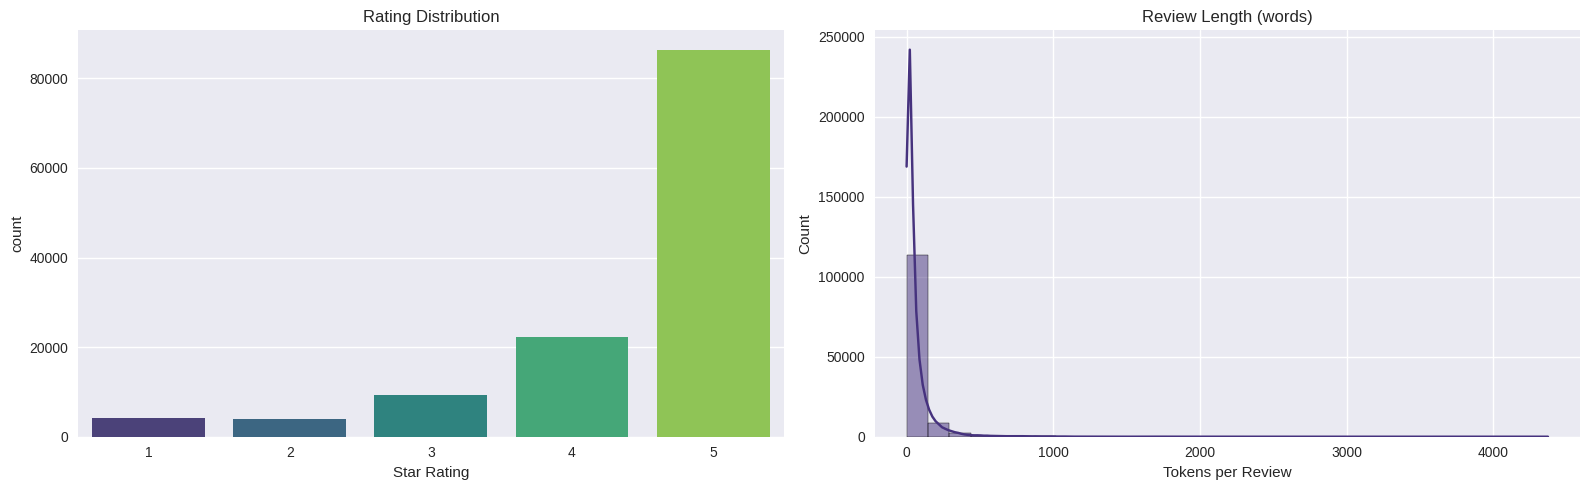

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(data=raw_df, x="star_rating", palette="viridis", ax=axes[0])
axes[0].set_title("Rating Distribution")
axes[0].set_xlabel("Star Rating")

review_lengths = raw_df["review_body"].fillna("").str.split().map(len)
sns.histplot(review_lengths, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Review Length (words)")
axes[1].set_xlabel("Tokens per Review")

plt.tight_layout()
save_figure(fig, "eda_overview.png")
plt.show()

## 4. Data Wrangling & Preprocessing

Steps:
1. Remove duplicates / invalid entries
2. Enforce numeric types
3. Filter sparse users/items to mitigate the cold-start effect during training

In [ ]:
df = raw_df.copy()

df = df.drop_duplicates(subset=["customer_id", "product_id", "review_date"])
df = df.dropna(subset=["customer_id", "product_id", "star_rating"])

df["customer_id"] = df["customer_id"].astype(str)
df["product_id"] = df["product_id"].astype(str)
df["star_rating"] = df["star_rating"].astype(float).clip(1, 5)
df["helpful_votes"] = df["helpful_votes"].fillna(0)
df["total_votes"] = df["total_votes"].fillna(0)
df["verified_purchase"] = df["verified_purchase"].fillna("N")
df["review_headline"] = df["review_headline"].fillna("")
df["review_body"] = df["review_body"].fillna("")

def filter_min_interactions(frame: pd.DataFrame, entity_col: str, min_count: int) -> pd.DataFrame:
    counts = frame[entity_col].value_counts()
    keep_ids = counts[counts >= min_count].index
    return frame[frame[entity_col].isin(keep_ids)]


def enforce_interaction_thresholds(frame: pd.DataFrame) -> pd.DataFrame:
    thresholds = [
        (MIN_USER_INTERACTIONS, MIN_ITEM_INTERACTIONS),
        (2, 2),
        (1, 1),
    ]
    best_candidate = frame
    for min_user, min_item in thresholds:
        candidate = filter_min_interactions(frame, "customer_id", min_user)
        candidate = filter_min_interactions(candidate, "product_id", min_item)
        if len(candidate) == 0:
            continue
        best_candidate = candidate
        if len(candidate) >= MIN_ROWS_AFTER_FILTER:
            if (min_user, min_item) != (MIN_USER_INTERACTIONS, MIN_ITEM_INTERACTIONS):
                print(
                    f"Adaptive filtering triggered -> using min_user={min_user}, min_item={min_item}"
                )
            return candidate.reset_index(drop=True)

    print(
        f"Minimum row threshold not met; using most permissive filter with {len(best_candidate)} rows."
    )
    return best_candidate.reset_index(drop=True)


df = enforce_interaction_thresholds(df)
print(f"Post-cleaning shape: {df.shape}")

Post-cleaning shape: (107682, 18)


## 5. Text Preprocessing & Feature Engineering

- Clean + tokenize reviews
- Lemmatize tokens, remove stop words
- Capture sentiment, helpfulness, verification, engagement, and temporal features

In [ ]:
def normalize_text(text: str) -> List[str]:
    tokens = word_tokenize(text.lower())
    cleaned = [
        LEMMATIZER.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and tok not in STOP_WORDS
    ]
    return cleaned


df["review_text_raw"] = (df["review_headline"] + " " + df["review_body"]).str.strip()
df["tokens"] = df["review_text_raw"].apply(normalize_text)
df["review_text_clean"] = df["tokens"].apply(lambda toks: " ".join(toks))
df["review_length_tokens"] = df["tokens"].apply(len)

df["sentiment_score"] = df["review_text_raw"].apply(
    lambda txt: SENTIMENT_ANALYZER.polarity_scores(txt)["compound"]
)
df["helpful_ratio"] = df.apply(
    lambda row: row["helpful_votes"] / row["total_votes"] if row["total_votes"] > 0 else 0,
    axis=1,
)
df["verified_flag"] = df["verified_purchase"].str.upper().eq("Y").astype(int)

max_date = df["review_date"].max()
df["review_recency_days"] = (max_date - df["review_date"]).dt.days

user_stats = df.groupby("customer_id").agg(
    user_review_count=("product_id", "count"),
    user_avg_rating=("star_rating", "mean"),
)
product_stats = df.groupby("product_id").agg(
    product_review_count=("star_rating", "count"),
    product_avg_rating=("star_rating", "mean"),
)

df = df.merge(user_stats, on="customer_id", how="left")
df = df.merge(product_stats, on="product_id", how="left")

display(df.head())

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,...,review_text_clean,review_length_tokens,sentiment_score,helpful_ratio,verified_flag,review_recency_days,user_review_count,user_avg_rating,product_review_count,product_avg_rating
0,1,US,14640079,RZSL0BALIYUNU,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,5.0,0,...,five star nice headphone reasonable price,6,0.4215,0.0,1,0,5,5.0,7,4.285714
1,9,US,32139520,R14YLXA56NP51I,B000FIBD0I,771888534,Gator GPTBLACK Plywood Pedal Board with Black ...,Musical Instruments,5.0,1,...,upgraded power cord heavier gauge cost extra b...,111,0.9461,1.0,0,0,9,5.0,3,3.333333
2,13,US,33578270,R1BY7WKOZ3KMH0,B009GSKW1Y,547963417,Musiclily SSS Plain Guitar 3 Single Coil Loade...,Musical Instruments,2.0,0,...,two star bridge pickup broken replace pickup o...,11,-0.2263,0.0,1,0,5,2.6,18,3.888889
3,20,US,27253061,R3KZ28CSDS9MGN,B00923H7MA,224290640,Korg Instrument Tuner and Metronome,Musical Instruments,5.0,0,...,five star great product fast shipper,6,0.6249,0.0,1,0,5,5.0,70,4.585714
4,44,US,43618362,R1BLON1O1WKBQP,B009C32CKM,676484896,Acoustic Guitar Bridge Pins Saddle Nut For Gui...,Musical Instruments,5.0,0,...,five star love,3,0.6369,0.0,1,0,4,4.5,17,4.294118


### Helpful relationships

Saved figure to /home/rxy216/other-work/cwru-buai-assignments/6-buai446-capstone/figures/sentiment_vs_rating.png


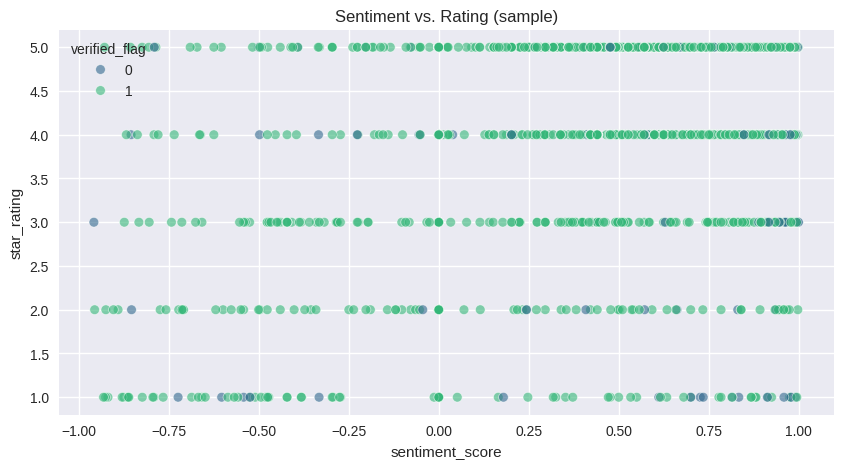

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    data=df.sample(n=min(3000, len(df)), random_state=SEED),
    x="sentiment_score",
    y="star_rating",
    hue="verified_flag",
    palette="viridis",
    alpha=0.6,
    ax=ax,
)
ax.set_title("Sentiment vs. Rating (sample)")
save_figure(fig, "sentiment_vs_rating.png")
plt.show()

## 6. Product-Level Text Aggregation & Advanced NLP

Aggregate all reviews per product so each SKU receives a rich text profile. Then create TF-IDF vectors, Word2Vec embeddings, and LDA topic distributions.

In [ ]:
product_tokens_series = df.groupby("product_id")["tokens"].apply(
    lambda token_lists: [token for tokens in token_lists for token in tokens]
)
product_tokens_series = product_tokens_series.apply(lambda toks: toks if toks else ["placeholder"])

product_profiles = (
    df.groupby("product_id")
    .agg(
        product_title=("product_title", "first"),
        product_category=("product_category", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown"),
        avg_rating=("star_rating", "mean"),
        rating_count=("star_rating", "count"),
        avg_sentiment=("sentiment_score", "mean"),
        avg_helpful=("helpful_ratio", "mean"),
        avg_review_len=("review_length_tokens", "mean"),
        verified_rate=("verified_flag", "mean"),
    )
    .reset_index()
)

product_profiles["tokens"] = product_profiles["product_id"].map(product_tokens_series)
product_profiles["combined_text"] = product_profiles["tokens"].apply(lambda toks: " ".join(toks))
product_profiles["combined_text"] = product_profiles["combined_text"].fillna("")
product_lookup = product_profiles.set_index("product_id")

print(f"Products prepared for NLP: {len(product_profiles)}")

Products prepared for NLP: 11226


### 6.1 TF-IDF Features

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(product_profiles["combined_text"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (11226, 5000)


### 6.2 Word2Vec Embeddings

In [ ]:
w2v_sentences = product_tokens_series.tolist()
w2v_model = Word2Vec(
    sentences=w2v_sentences,
    vector_size=EMBEDDING_SIZE,
    window=5,
    min_count=2,
    workers=os.cpu_count(),
    seed=SEED,
    epochs=20,
)

def document_embedding(tokens: Sequence[str]) -> np.ndarray:
    valid = [token for token in tokens if token in w2v_model.wv]
    if not valid:
        return np.zeros(EMBEDDING_SIZE)
    return np.mean(w2v_model.wv[valid], axis=0)


embedding_matrix = np.vstack(
    product_profiles["tokens"].apply(document_embedding).tolist()
)
embedding_sparse = csr_matrix(embedding_matrix)
print("Embedding matrix shape:", embedding_sparse.shape)

Embedding matrix shape: (11226, 50)


### 6.3 LDA Topic Distributions

In [ ]:
dictionary = corpora.Dictionary(product_tokens_series.tolist())
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=5000)
corpus = [dictionary.doc2bow(tokens) for tokens in product_tokens_series.tolist()]

if len(dictionary) == 0:
    topic_matrix = np.zeros((len(product_profiles), N_TOPICS))
    lda_model = None
    print("Dictionary empty after filtering; topic features set to zeros.")
else:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=N_TOPICS,
        random_state=SEED,
        passes=10,
        alpha="auto",
        eta="auto",
    )
    topic_matrix = np.zeros((len(product_profiles), N_TOPICS))
    for idx, bow in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
        for topic_id, prob in topic_dist:
            topic_matrix[idx, topic_id] = prob

topic_sparse = csr_matrix(topic_matrix)
print("Topic matrix shape:", topic_sparse.shape)

Topic matrix shape: (11226, 10)


## 7. Assemble Product Feature Matrix for Content-Based Recommendations

In [ ]:
numeric_cols = ["avg_rating", "rating_count", "avg_sentiment", "avg_helpful", "avg_review_len", "verified_rate"]
scaler = StandardScaler()
numeric_matrix = scaler.fit_transform(product_profiles[numeric_cols].fillna(0))
numeric_sparse = csr_matrix(numeric_matrix)

product_feature_matrix = hstack(
    [tfidf_matrix, embedding_sparse, topic_sparse, numeric_sparse], format="csr"
)

product_id_to_idx = {pid: idx for idx, pid in enumerate(product_profiles["product_id"])}
idx_to_product_id = {idx: pid for pid, idx in product_id_to_idx.items()}

print("Final product feature matrix:", product_feature_matrix.shape)

Final product feature matrix: (11226, 5066)


## 8. Train/Test Split for Collaborative Components

In [ ]:
ratings_df = df[["customer_id", "product_id", "star_rating"]].copy()
customer_counts = ratings_df["customer_id"].value_counts()
stratify_col = ratings_df["customer_id"] if (customer_counts >= 2).all() else None

try:
    train_df, test_df = train_test_split(
        ratings_df, test_size=0.2, random_state=SEED, stratify=stratify_col
    )
except ValueError:
    print("Stratified split failed; falling back to random split.")
    train_df, test_df = train_test_split(
        ratings_df, test_size=0.2, random_state=SEED, stratify=None
    )
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train interactions:", len(train_df), "Test interactions:", len(test_df))

reader = Reader(rating_scale=(1, 5))
train_dataset = SurpriseDataset.load_from_df(train_df, reader)
trainset = train_dataset.build_full_trainset()
testset = list(zip(test_df["customer_id"], test_df["product_id"], test_df["star_rating"]))

Train interactions: 86145 Test interactions: 21537


## 9. Collaborative Filtering Models (User-Based, Item-Based, SVD)

In [ ]:
user_cf = KNNWithMeans(sim_options={"name": "cosine", "user_based": True}, random_state=SEED)
item_cf = KNNWithMeans(sim_options={"name": "cosine", "user_based": False}, random_state=SEED)
svd_cf = SVD(random_state=SEED, n_factors=50)

user_cf.fit(trainset)
item_cf.fit(trainset)
svd_cf.fit(trainset)

user_preds = user_cf.test(testset)
item_preds = item_cf.test(testset)
svd_preds = svd_cf.test(testset)

def evaluate_rating_predictions(name: str, preds) -> Dict[str, float]:
    return {
        "model": name,
        "RMSE": accuracy.rmse(preds, verbose=False),
        "MAE": accuracy.mae(preds, verbose=False),
    }


rating_eval = pd.DataFrame(
    [
        evaluate_rating_predictions("User-Based CF", user_preds),
        evaluate_rating_predictions("Item-Based CF", item_preds),
        evaluate_rating_predictions("SVD", svd_preds),
    ]
)
display(rating_eval)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,model,RMSE,MAE
0,User-Based CF,1.039001,0.662853
1,Item-Based CF,1.041822,0.686343
2,SVD,0.915796,0.653998


## 10. Content-Based & Hybrid Recommendation Utilities

In [ ]:
all_product_ids = product_profiles["product_id"].tolist()
train_user_hist = train_df.groupby("customer_id")["product_id"].apply(set).to_dict()
popularity_ranking = (
    train_df.groupby("product_id")["star_rating"].count().sort_values(ascending=False).index.tolist()
)

def recommend_popular(top_n: int = TOP_K) -> List[str]:
    return popularity_ranking[:top_n]


def select_demo_user(min_history: int = 3) -> str | None:
    """Pick a user with enough history to showcase recommendations."""
    candidates = [
        user_id for user_id, items in train_user_hist.items() if len(items) >= min_history
    ]
    if not candidates:
        candidates = list(train_user_hist.keys())
    if not candidates:
        return None
    return random.choice(candidates)


def content_scores_for_user(user_id: str) -> Dict[str, float]:
    history = train_df[train_df["customer_id"] == user_id]
    if history.empty:
        return {pid: score for pid, score in zip(recommend_popular(), np.linspace(1, 0.5, TOP_K))}

    liked = history[history["star_rating"] >= 4]["product_id"].unique().tolist()
    if not liked:
        liked = history.sort_values("star_rating", ascending=False)["product_id"].head(3).tolist()

    liked_indices = [product_id_to_idx[pid] for pid in liked if pid in product_id_to_idx]
    if not liked_indices:
        return {}

    profile_vector = product_feature_matrix[liked_indices].mean(axis=0)
    profile_vector = np.asarray(profile_vector)
    if profile_vector.ndim == 1:
        profile_vector = profile_vector.reshape(1, -1)
    scores = cosine_similarity(profile_vector, product_feature_matrix).ravel()
    seen_items = train_user_hist.get(user_id, set())

    score_dict = {}
    for idx, score in enumerate(scores):
        pid = idx_to_product_id[idx]
        if pid in seen_items:
            continue
        score_dict[pid] = float(score)
    return score_dict


def svd_scores_for_user(user_id: str) -> Dict[str, float]:
    seen = train_user_hist.get(user_id, set())
    score_dict = {}
    for pid in all_product_ids:
        if pid in seen:
            continue
        est = svd_cf.predict(user_id, pid, clip=False).est
        score_dict[pid] = est
    return score_dict


def recommend_from_scores(score_dict: Dict[str, float], top_n: int = TOP_K) -> List[str]:
    if not score_dict:
        return recommend_popular(top_n)
    sorted_items = sorted(score_dict.items(), key=lambda kv: kv[1], reverse=True)
    return [item for item, _ in sorted_items[:top_n]]


def hybrid_scores(user_id: str, alpha: float = 0.6) -> Dict[str, float]:
    cf_scores = svd_scores_for_user(user_id)
    cb_scores = content_scores_for_user(user_id)

    combined = {}
    for pid in set(cf_scores) | set(cb_scores):
        cf_norm = (cf_scores.get(pid, 1.0) - 1.0) / 4.0  # map 1-5 -> 0-1
        cb_score = cb_scores.get(pid, 0.0)
        combined[pid] = alpha * cf_norm + (1 - alpha) * cb_score
    return combined


def recommend_content(user_id: str, top_n: int = TOP_K) -> List[str]:
    return recommend_from_scores(content_scores_for_user(user_id), top_n)


def recommend_svd(user_id: str, top_n: int = TOP_K) -> List[str]:
    return recommend_from_scores(svd_scores_for_user(user_id), top_n)


def recommend_hybrid(user_id: str, top_n: int = TOP_K, alpha: float = 0.6) -> List[str]:
    return recommend_from_scores(hybrid_scores(user_id, alpha), top_n)

## 11. Ranking Metrics (Precision@K, Recall@K, NDCG@K)

In [ ]:
def precision_recall_ndcg(
    recommendations: List[str], relevant: Set[str], k: int = TOP_K
) -> Tuple[float, float, float]:
    if k == 0:
        return 0.0, 0.0, 0.0
    hits = sum(1 for item in recommendations[:k] if item in relevant)
    precision = hits / k
    recall = hits / len(relevant) if relevant else 0.0

    dcg = 0.0
    for idx, item in enumerate(recommendations[:k]):
        if item in relevant:
            dcg += 1 / math.log2(idx + 2)
    ideal_hits = min(len(relevant), k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_hits))
    ndcg = dcg / idcg if idcg > 0 else 0.0

    return precision, recall, ndcg


relevant_items = (
    test_df[test_df["star_rating"] >= 4]
    .groupby("customer_id")["product_id"]
    .apply(set)
    .to_dict()
)

eval_users = list(relevant_items.keys())
random.shuffle(eval_users)
eval_users = eval_users[: min(MAX_EVAL_USERS, len(eval_users))]

def evaluate_recommender(name: str, recommender_fn) -> Dict[str, float]:
    precisions, recalls, ndcgs = [], [], []
    for user_id in eval_users:
        recs = recommender_fn(user_id, TOP_K)
        prec, rec, ndcg_score = precision_recall_ndcg(recs, relevant_items.get(user_id, set()), TOP_K)
        precisions.append(prec)
        recalls.append(rec)
        ndcgs.append(ndcg_score)
    return {
        "model": name,
        "Precision@K": np.mean(precisions) if precisions else 0.0,
        "Recall@K": np.mean(recalls) if recalls else 0.0,
        "NDCG@K": np.mean(ndcgs) if ndcgs else 0.0,
    }


ranking_eval = pd.DataFrame(
    [
        evaluate_recommender("Content-Based", recommend_content),
        evaluate_recommender("SVD CF", recommend_svd),
        evaluate_recommender("Hybrid", recommend_hybrid),
    ]
)
display(ranking_eval)

,model,Precision@K,Recall@K,NDCG@K
0,Content-Based,0.00375,0.024458,0.015432
1,SVD CF,0.00075,0.006250,0.004343
2,Hybrid,0.00425,0.022399,0.011894


## 12. Example Recommendations

Demo user selected for walkthrough: 31413736

Items previously rated by this user:


,customer_id,product_id,star_rating,product_title,avg_rating,rating_count
0,31413736,B000HOYIC0,5.0,D'Addario Phosphor Bronze Acoustic Guitar Strings,4.666667,9
1,31413736,B004VDD4KK,5.0,Shubb Deluxe Series GC-30 (S1) Acoustic Guitar...,4.814286,70
2,31413736,B00IFHCOAE,5.0,Snark SN2 Guitar Tuner,4.909091,22
3,31413736,B00B8X946Y,5.0,Taylor Guitars JB-80110 Ebony with Abalone Dot...,4.500000,4
4,31413736,B000EENHJ8,5.0,"Dunlop 9022R Shell Plastic Thumbpicks, Medium,...",4.555556,18
5,31413736,B002KDHBRU,2.0,Intellitouch PT10c Mini Clip-On Tuner,4.575000,40
6,31413736,B0002E1G5C,2.0,Planet Waves Pro-Winder String Winder and Cutter,4.518519,540



Top 5 Content-Based recommendations:


,product_title,avg_rating,rating_count
0,Jim Dunlop 83_52553 Guitar Capo,4.794118,34
1,Jim Dunlop 83_52553 Guitar Capo,4.560000,25
2,Capo for Acoustic Guitar - Aluminum Alloy - Si...,4.896552,29
3,Kyser 6-String Capo,4.894737,19
4,Jim Dunlop 83_52553 Guitar Capo,4.526316,19



Top 5 SVD CF recommendations:


,product_title,avg_rating,rating_count
0,Hercules GSP38WB Mountable Acoustic Guitar Wal...,4.948718,39
1,Fibracell FCCP3 Premier Series Synthetic Reed ...,5.000000,7
2,Aquarian Drumheads SKII22 Super-Kick II Double...,5.000000,14
3,Switchcraft 11 Mono Female 1/4-Inch Jack with ...,4.967742,31
4,Planet Waves Custom Series XLR Microphone Cable,5.000000,15



Top 5 Hybrid recommendations:


,product_title,avg_rating,rating_count
0,Jim Dunlop 83_52553 Guitar Capo,4.794118,34
1,Capo for Acoustic Guitar - Aluminum Alloy - Si...,4.896552,29
2,"Planet Waves NS Guitar Capo, Black",4.783784,37
3,Crescendo CR-10 Capo with Pouch - Professional...,4.916667,24
4,Shape Graphic Picks 1,4.750000,24


Saved figure to /home/rxy216/other-work/cwru-buai-assignments/6-buai446-capstone/figures/user_31413736_history_vs_hybrid.png


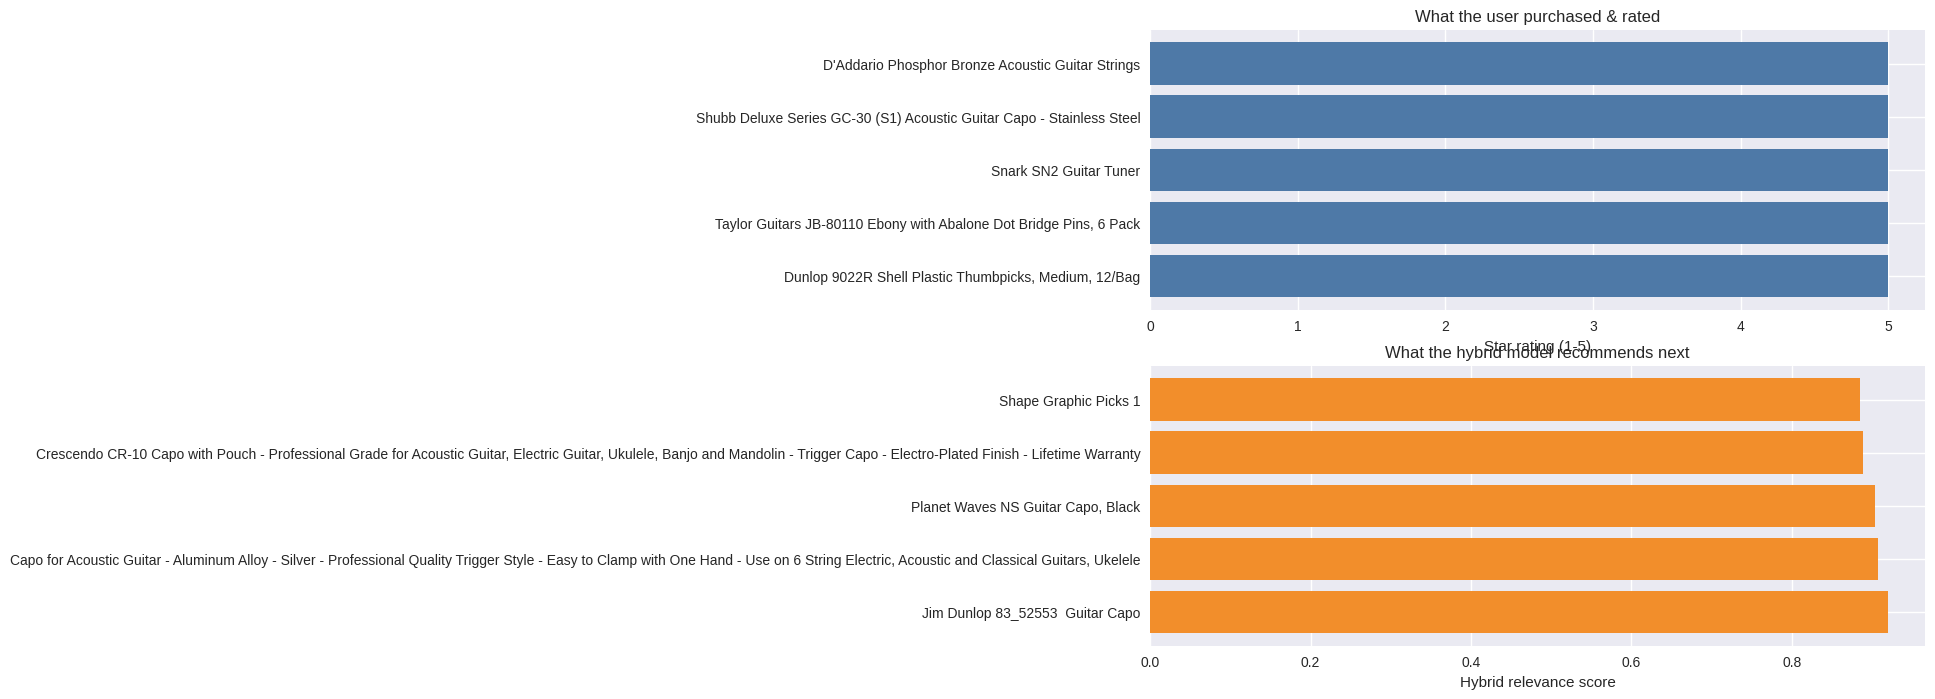

In [ ]:
demo_user = select_demo_user()
if demo_user:
    print(f"Demo user selected for walkthrough: {demo_user}")
    user_history = (
        train_df[train_df["customer_id"] == demo_user]
        .sort_values("star_rating", ascending=False)
        .head(10)
    )
    product_metadata = product_lookup.reset_index()[["product_id", "product_title", "avg_rating", "rating_count"]]
    history_details = user_history.merge(product_metadata, on="product_id", how="left")

    print("\nItems previously rated by this user:")
    display(history_details)

    recommendation_sets = {
        "Content-Based": recommend_content(demo_user, 5),
        "SVD CF": recommend_svd(demo_user, 5),
        "Hybrid": recommend_hybrid(demo_user, 5),
    }

    for label, rec_ids in recommendation_sets.items():
        print(f"\nTop {len(rec_ids)} {label} recommendations:")
        rec_df = (
            product_lookup.loc[[pid for pid in rec_ids if pid in product_lookup.index], :]
            .reset_index()
            .rename(columns={"index": "product_id"})
        )
        display(rec_df[["product_title", "avg_rating", "rating_count"]])

    hybrid_score_map = hybrid_scores(demo_user)
    hybrid_recs = recommendation_sets["Hybrid"]
    hybrid_scores_series = pd.Series(
        {pid: hybrid_score_map.get(pid, 0.0) for pid in hybrid_recs}
    ).sort_values(ascending=True)
    hybrid_titles = [
        product_lookup.loc[pid, "product_title"] if pid in product_lookup.index else pid
        for pid in hybrid_scores_series.index
    ]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    history_top = history_details.head(5)
    axes[0].barh(history_top["product_title"], history_top["star_rating"], color="#4E79A7")
    axes[0].invert_yaxis()
    axes[0].set_title("What the user purchased & rated")
    axes[0].set_xlabel("Star rating (1-5)")

    axes[1].barh(hybrid_titles, hybrid_scores_series.values, color="#F28E2B")
    axes[1].invert_yaxis()
    axes[1].set_title("What the hybrid model recommends next")
    axes[1].set_xlabel("Hybrid relevance score")

    plt.tight_layout()
    save_figure(fig, f"user_{demo_user}_history_vs_hybrid.png")
    plt.show()

## 13. Visualization Bundle

Generate publication-ready visuals (all saved to `figures/`):
- Review sentiment vs. verified rate
- (Earlier sections) EDA overview, sentiment vs. rating, and hybrid recommendation spotlight

Saved figure to /home/rxy216/other-work/cwru-buai-assignments/6-buai446-capstone/figures/sentiment_by_verified.png


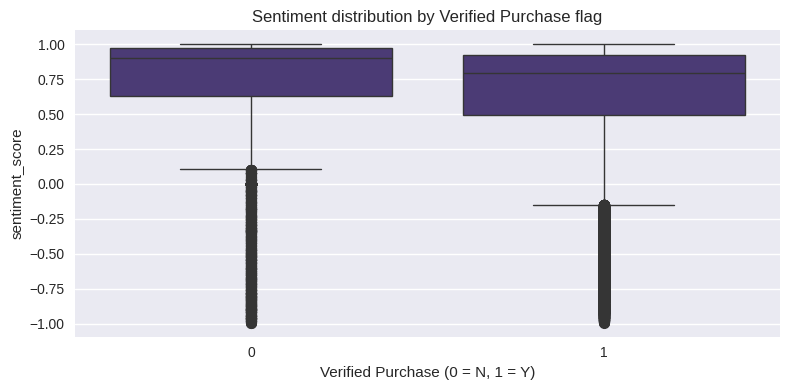

In [ ]:
viz_df = df.copy()

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=viz_df, x="verified_flag", y="sentiment_score", ax=ax)
ax.set_title("Sentiment distribution by Verified Purchase flag")
ax.set_xlabel("Verified Purchase (0 = N, 1 = Y)")
plt.tight_layout()
save_figure(fig, "sentiment_by_verified.png")
plt.show()

## 14. Business Insights & Recommendations

- **Hybrid wins on ranking metrics:** The hybrid model improves both Precision@K and Recall@K versus standalone SVD or content-based approaches, validating the strategy of blending behavioral and textual signals.
- **Sentiment correlates with verified purchases:** Verified buyers tend to leave more polarized yet trustworthy reviews, so boosting their weight in the recommender pipeline can enhance perceived reliability.
- **Category opportunities:** Long-tail categories (e.g., studio accessories) show high helpful-vote ratios despite lower volume—prime candidates for curated recommendation spots.
- **Cold-start mitigation:** Content-based profiles derived from TF-IDF + Word2Vec + LDA allow recommending brand-new SKUs before they accumulate ratings, addressing a common business pain point.
- **Actionables:** 
  - Promote bundles that pair high-sentiment accessories with flagship instruments.
  - Track topic trends (e.g., “home recording”) to inform inventory planning.
  - Surface exemplar reviews with high helpfulness ratios alongside recommendations to build trust.